<a href="https://colab.research.google.com/github/sokanaid/CourseProject2022BiologicalMath/blob/main/find_plateau_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подбор порога остановы на плато

In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [11]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/sim_tables

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/sim_tables


## Чтение данных

In [12]:
def read_csv_file(directory_path, name):
  file_path = os.path.join(directory_path, name + ".csv")
  # print("read file ", file_path)
  return pd.read_csv(file_path)

In [13]:
def read_description(directory_path, file_name = "description.txt", parse_params = False):
  file_path = os.path.join(directory_path, file_name)
  # print("read description from file  ", file_path)
  with open(file_path, 'r') as file:
    if not parse_params:
      return file.read()
    result = {}
    for line in file:
      name, value = line.split('=')
      value = value.strip(' \t\n\r')
      if value == 'TRUE':
        value = True
      elif value == 'FALSE':
        value = False
      else:
        try:
          value = float(value)
        except:
          try:
            value = int(value)
          except:
            ...
      result[name] = value
    return result

In [14]:
def read_files(directory_path):
  data = {}
  # строковое описание параметров
  data["description_str"] = read_description(directory_path)
  # описание параметров в виде словаря
  data["params"] =  read_description(directory_path, parse_params = True)
  # численность популяции
  data["population"] = read_csv_file(directory_path, "population")
  data["population"].drop(data["population"].tail(1).index, inplace=True)
  data["population"].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  # результаты последовательных сглаживаний численности популяции
  name = "exp_pop10"
  data[name] = read_csv_file(directory_path, name)
  data[name].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  return data

In [15]:
# читаем все результаты симуляций из папок 
def read_all_simulations(directories_paths):
  data = []
  for directory_path in directories_paths:
    for simulation_diractory_name in os.listdir(directory_path):
      simulation_diractory_path = os.path.join(directory_path, simulation_diractory_name)
      if os.path.isdir(simulation_diractory_path):
        result = read_files(simulation_diractory_path)
        # только симуляции без поиска плато и принудительной остановки по достижению предела времени исполнения
        if not result["params"]['auto_stop_at_plateau'] and not result["params"]['realtime_limit_reached']:
          data.append(result)
  return data

## Построение графиков

In [16]:
def print_all_in_one_frame(Data, x="time", y = "population", limit = 25000):
  limit = min(limit, len(Data[0][y]))
  if y== "exp_pop":
    type_d = "exp_pop"
  if 'exp' in y and y!="exp_pop":
    type_d = "exp_pop2"
  else:
    type_d = "pop"
  fig = plt.figure(figsize=(40, 5), dpi=80)
  plt.axis('off')
  plt.title("Simulations" )
  #fig.tight_layout(pad=6.0,  h_pad=3, w_pad=3)
  fig.patch.set_visible(False)
  axes = fig.subplots(nrows=1, ncols=1)
  for i, data_ in enumerate(Data):
    axes.plot(data_[y][x][:limit], data_[y][type_d][:limit], label="#"+str(i))
    axes.set_xlabel(x)
    axes.set_ylabel(y)
  axes.legend(loc="lower right")


## Работа с симуляциями


In [17]:
directories = list(set([
               "/content/drive/MyDrive/sim_tables/kurkin2",
               "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks", 
               "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks2",
               "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks3",
               "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks4",
               "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks5",
               "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks6",
               "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks7",
               "/content/drive/MyDrive/sim_tables/kurkin_b=02_d=002",
               "/content/drive/MyDrive/sim_tables/smoothing",
               ]))
data = read_all_simulations(directories)

In [18]:
data[0]['params']

{'dd': 0.75,
 'death_r': 600.0,
 'epochs_count': 25000.0,
 'plateau_threshold': 8.0,
 'area_length_x': 6000.0,
 'initial_pop': 100.0,
 'auto_stop_at_plateau': False,
 'b': 100.0,
 'd': 0.0,
 'sd_b': 0.7,
 'sd_d': 0.6,
 'found_plateau': False,
 'realtime_limit_reached': False}

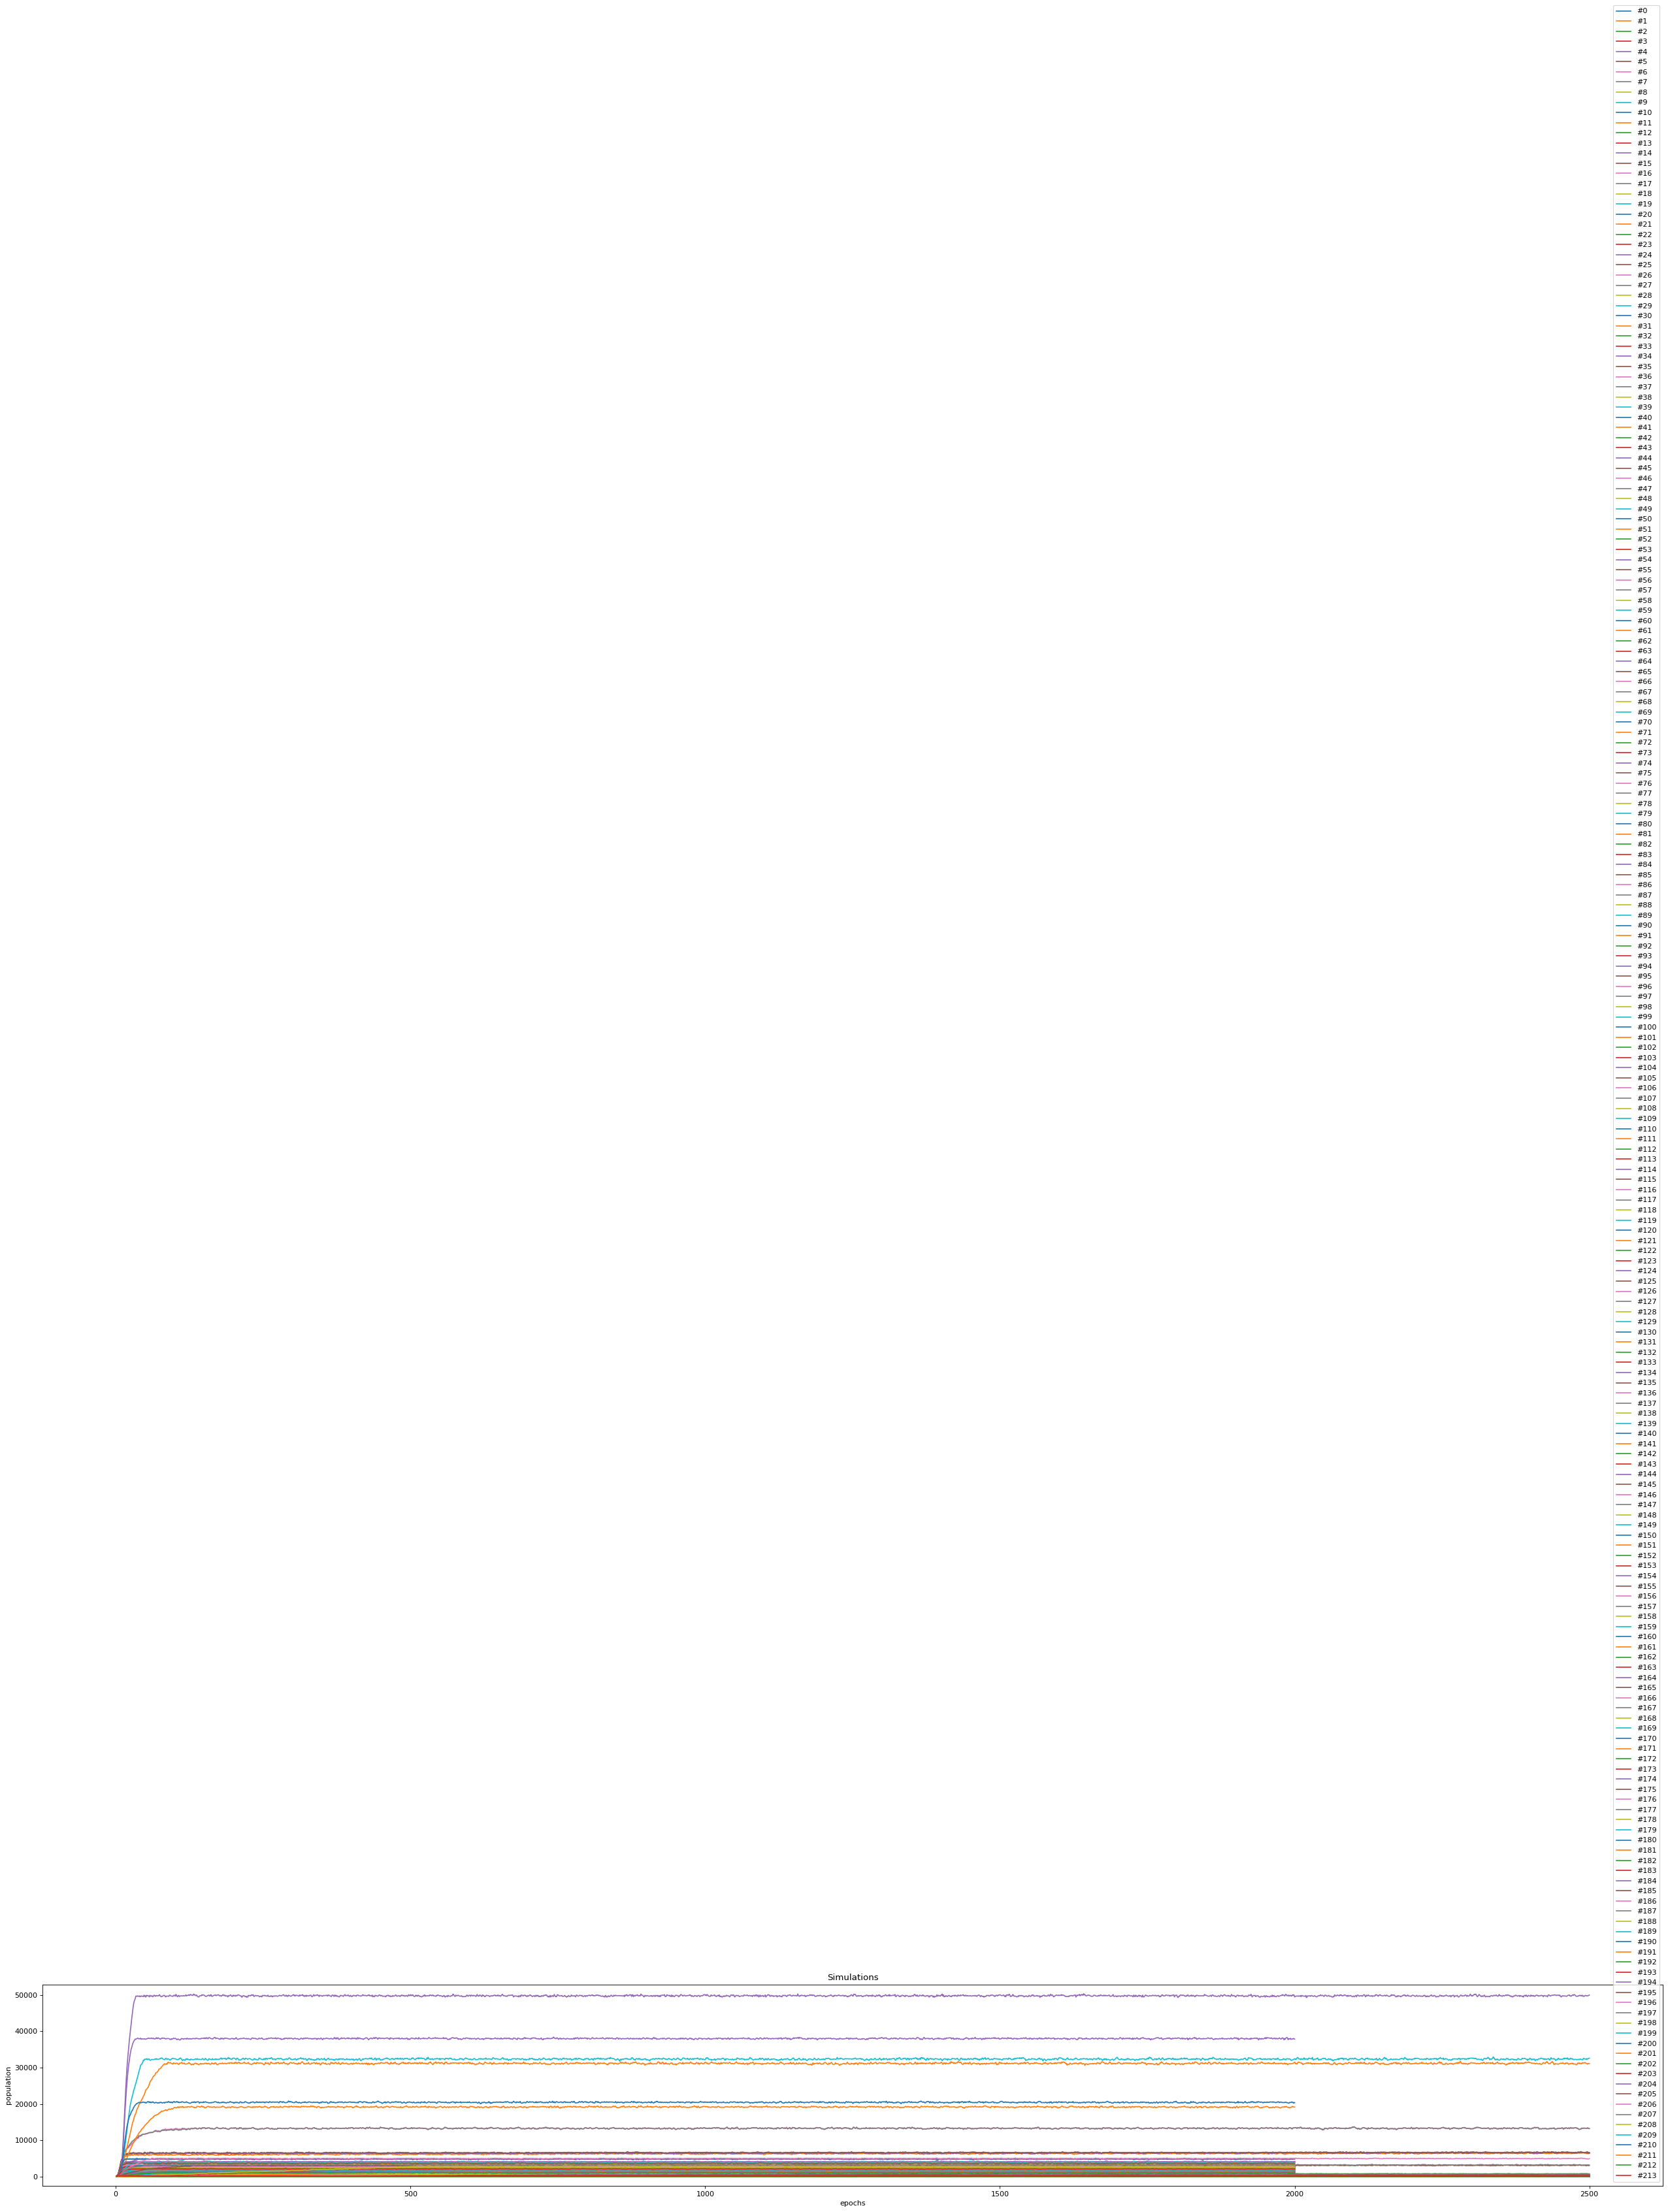

In [19]:
# построим все графики 
print_all_in_one_frame([data_ for data_ in data if not data_["params"]['auto_stop_at_plateau'] and not data_["params"]['realtime_limit_reached']] ,x = "epochs", limit = 2500)

In [20]:
data[0]["exp_pop10"]

,epochs,time,exp_pop2
0,1,0.000000,100.000000
1,2,0.008018,106.000000
2,3,0.014887,126.375000
3,4,0.021797,173.187500
4,5,0.028320,262.570312
...,...,...,...
24996,24997,124.984617,6577.903754
24997,24998,124.989536,6580.144942
24998,24999,124.994518,6586.646551
24999,25000,124.999482,6594.013296


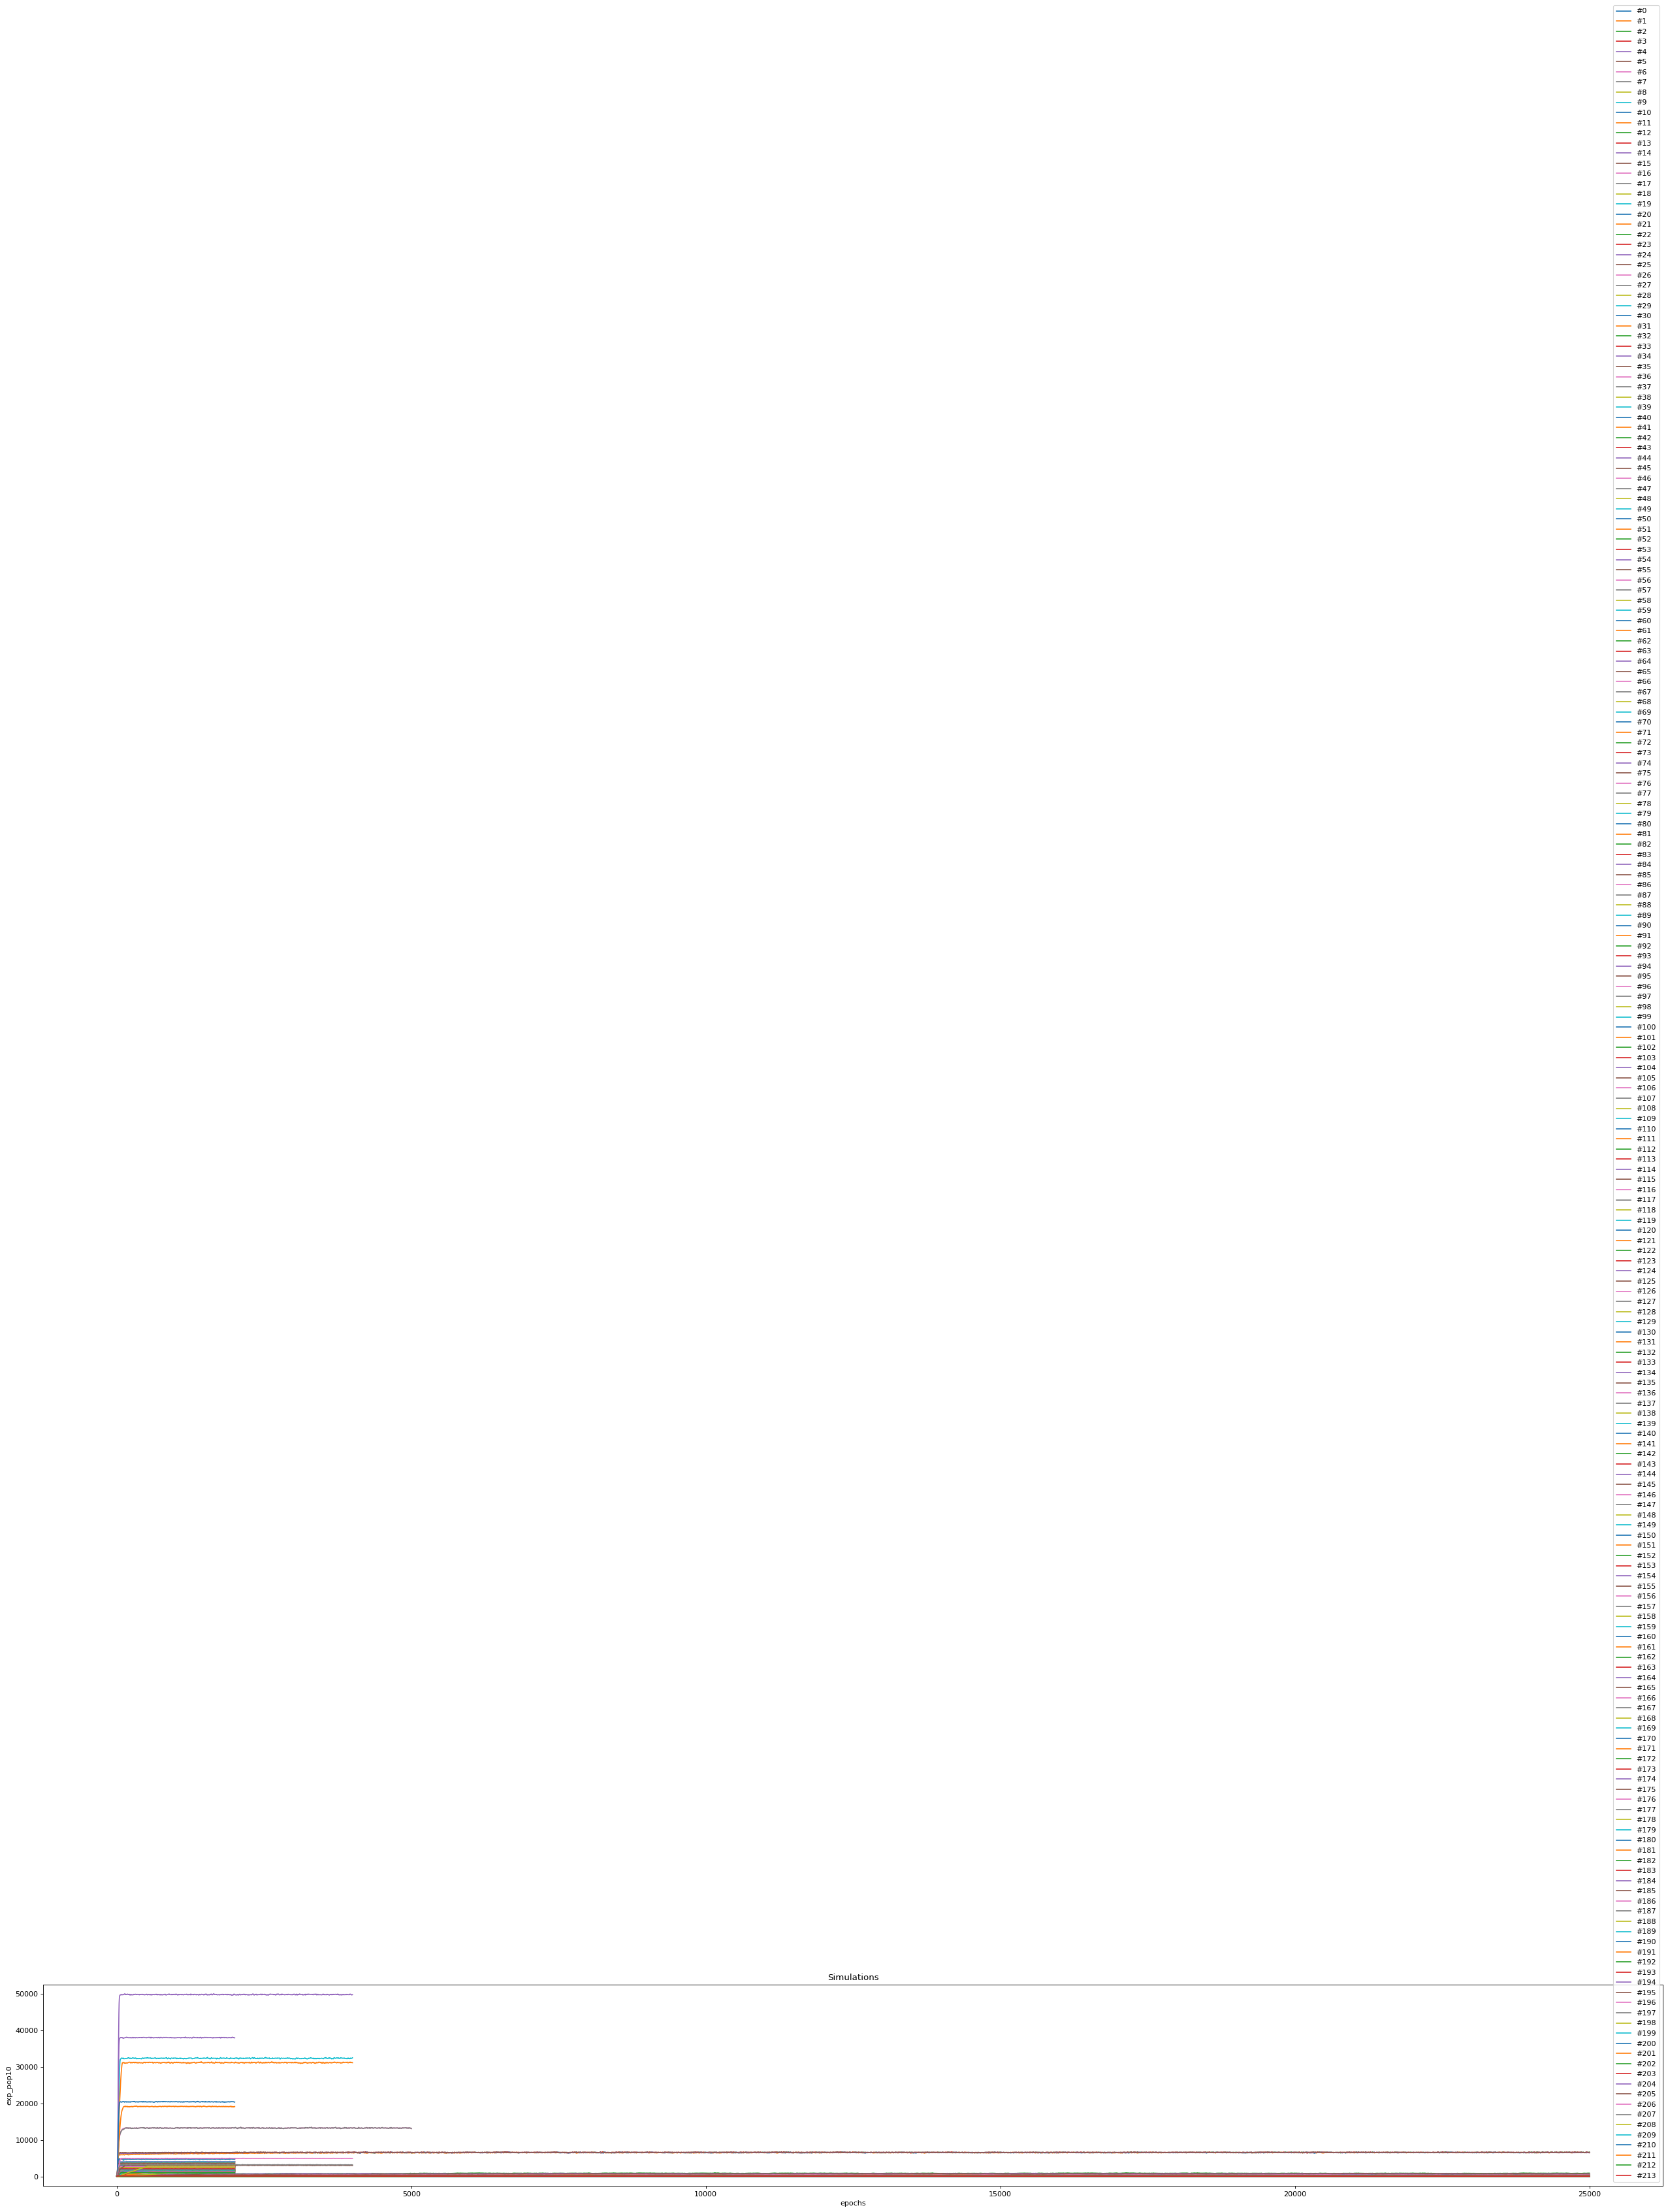

In [21]:
# построим все графики после 10 экспоненциального сглаживания
print_all_in_one_frame([data_ for data_ in data if not data_["params"]['auto_stop_at_plateau'] and not data_["params"]['realtime_limit_reached']] ,x = "epochs", y = "exp_pop10")

## Подбор окна сглаживания

       epochs        time     exp_pop2
0           1    0.000000   100.000000
1           2    0.007893   106.125000
2           3    0.015256   127.062500
3           4    0.021657   176.023438
4           5    0.028109   269.687500
...       ...         ...          ...
24996   24997  124.988889  6543.527423
24997   24998  124.993796  6533.028044
24998   24999  124.998785  6528.932891
24999   25000  125.003743  6530.696061
25000   25001  125.008710  6540.519341

[25001 rows x 3 columns]


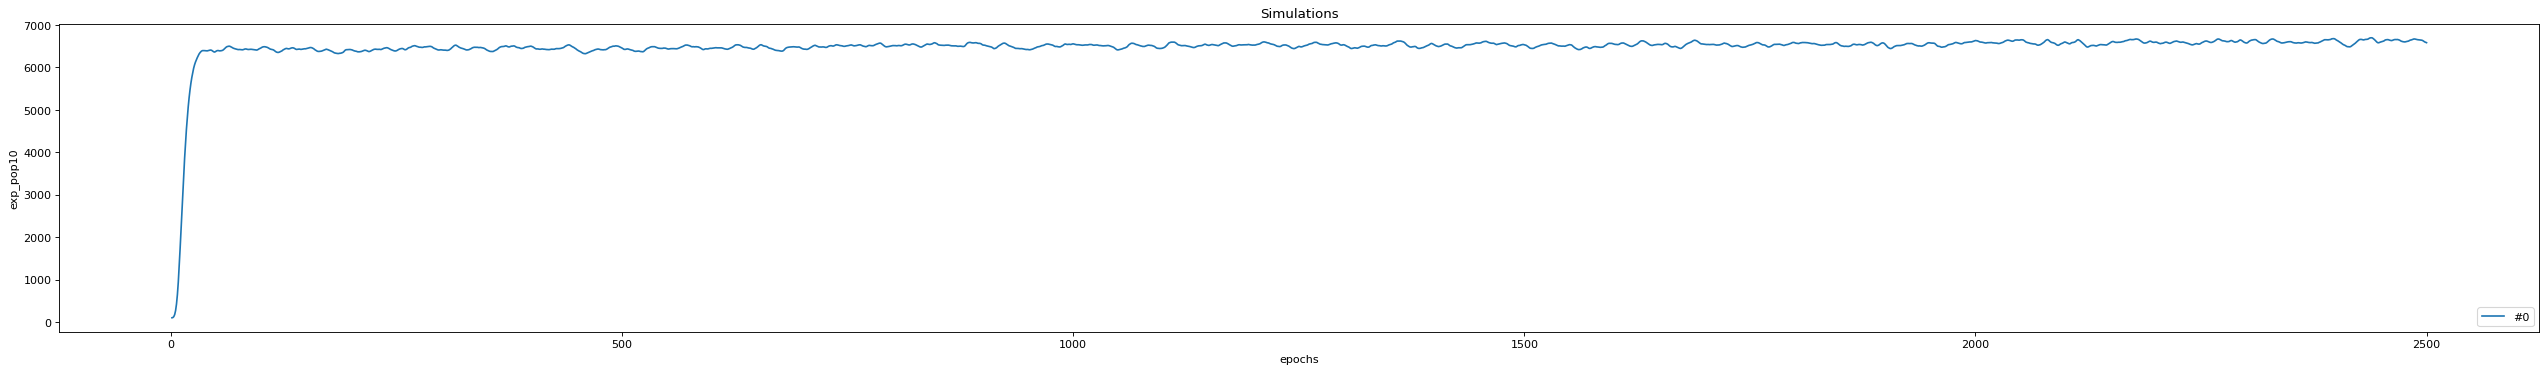

[3414741.8158752457, 1697.3653868353772, 1564.5934873245074, 1489.2563145062747, 2310.27539306666, 1454.6585244524465, 1339.0009368533076, 864.2161481197269, 778.5891864746778, 1871.5669325691304, 1434.5443035767676, 864.7285281576832, 1419.8696058118578, 2170.280320766118, 1557.6336432896087, 1683.9129150961132, 2041.208661330826, 800.4608105418945, 724.3420272435385, 1803.2091584694272, 1277.4359570726845, 2393.9287886304664, 934.6059301122726, 1132.2670035477647, 2639.5109913966135, 1476.6211601720324, 1047.9218871787991, 1813.647017251493, 1335.4313239922928, 1005.5127793225153, 574.7864999720962, 1524.9488027919072, 1271.403082210902, 1713.921621005582, 1712.292357732608, 1069.418102511665, 1084.0787136751776, 1295.075959855447, 1105.081466955402, 1061.6503607072948, 1672.237822364648, 2157.6142302732337, 3095.006033609247, 1796.3286565710705, 531.3380111569961, 1802.0308943100958, 2710.7860276428505, 900.168788780535, 2448.6352799397177, 2118.865502099022, 810.158119080329, 1753.

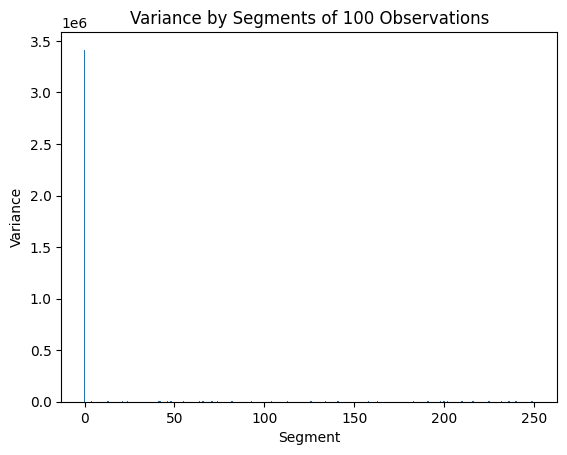

[1313455.5881655563, 1811.2560237915225, 1794.9008894363458, 1591.5193922684748, 1815.8040406431653, 1848.723155519017, 1801.4199818099084, 1593.2172255124901, 1749.2088603406703, 1398.8105417121535, 1230.770215703141, 1529.2148743045102, 1184.5370329701038, 1850.084543104202, 2348.776127686628, 1837.1382922670214, 1874.4608199603829, 1767.2865695032901, 2033.3952644337166, 1301.9970621963578, 1516.166489656363, 1684.3574482332003, 2169.8616834454047, 1669.124889160872, 1512.0040562219115, 2025.5828260415622, 1584.8174911754409, 2314.6267465561286, 1609.9665512084089, 1084.3368683009278, 1233.8462785852328, 1420.2069299979485, 1734.7596279962202, 1969.2293499332302, 1950.100984314798, 1296.7819599423829, 1435.3881667787919, 2682.790039522929, 1236.493994984029, 1598.14893897569, 1704.1792202345619, 1255.3136337772091, 1453.7149610630652, 1390.695881369606, 2283.4921362115165, 954.9507218251704, 1414.413259510562, 1414.32761105543, 1494.540922906417, 1790.9621911534034, 875.703080969363

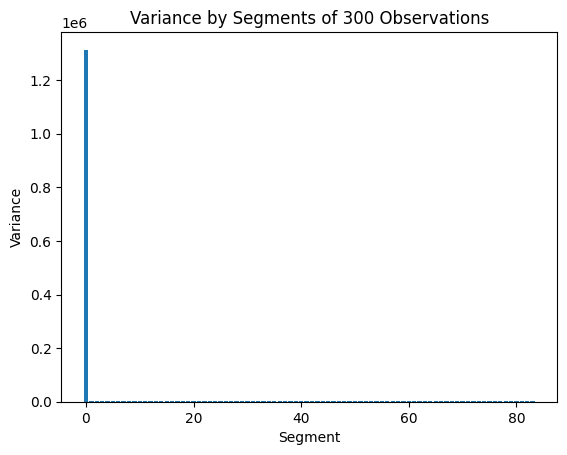

[813068.0232819562, 2158.9234303694216, 1642.990034531621, 1688.5897409329832, 1824.4651136628343, 1356.2565790867486, 1465.464123342663, 1247.7313272305341, 2289.868869336461, 2136.1882092789347, 1608.011283716768, 1816.1513525791518, 1622.1472722927035, 2046.589518694787, 1574.060378242226, 1976.1630845705033, 1853.8448087843328, 1431.1019517026384, 1422.214322902889, 1640.2713195731635, 1984.298401054321, 1201.6415684410747, 2480.570215049154, 1522.0833300122197, 1632.1432461954994, 1499.5874806135328, 1869.042320149329, 1102.8153277648519, 1513.2157302892529, 1773.3912749963454, 1115.132261151635, 1788.7459542642507, 1818.5826486972762, 1297.6709671203662, 1863.2558336335985, 1251.2619657454056, 1356.8190418172403, 1552.6944667645762, 2178.6571491593077, 1653.097379864639, 2233.214142789934, 1515.8258774667163, 1688.0524886639828, 1290.8762429817032, 1270.2713499100332, 1931.2334111992147, 1563.8630969553997, 1486.972789080573, 1903.6574628308276, 1775.0485895486609, 0.0]
51


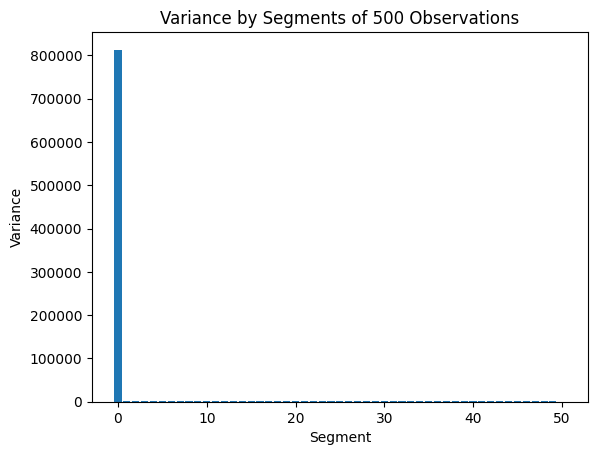

[421177.1060709772, 1692.8966704692766, 1596.929563956689, 1371.1816414028708, 2217.722419145115, 1713.7150400548273, 1900.9320966662892, 1837.2300099803524, 1751.546481837545, 1533.5626875133867, 1633.2646270674927, 2008.713691023421, 1727.5725657631997, 1489.405192118022, 1719.1387561169793, 1469.572675573217, 1628.9485717252326, 1565.2983952253107, 1461.0041364436593, 2028.132206077005, 1875.0754534460957, 1490.2175498239314, 1600.9299346979774, 1527.42944556024, 1878.8114052634844, 0.0]
26


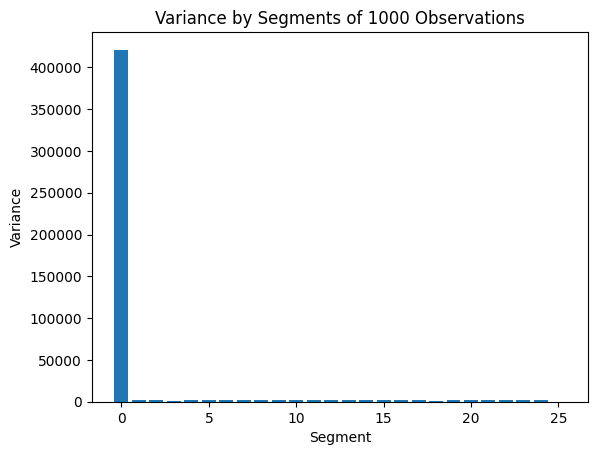

[286370.4944131426, 2695.7901066436843, 1697.771510523218, 1892.438832301521, 1792.0726016903836, 1837.447941590233, 1729.9813046911347, 1739.9404115653886, 1781.4484787446838, 1522.1804959887638, 1661.8033108871957, 1505.8682984294876, 1810.908098683477, 1801.5693455084177, 1447.9987588654117, 1665.5636192981551, 1882.4030296385915]
17


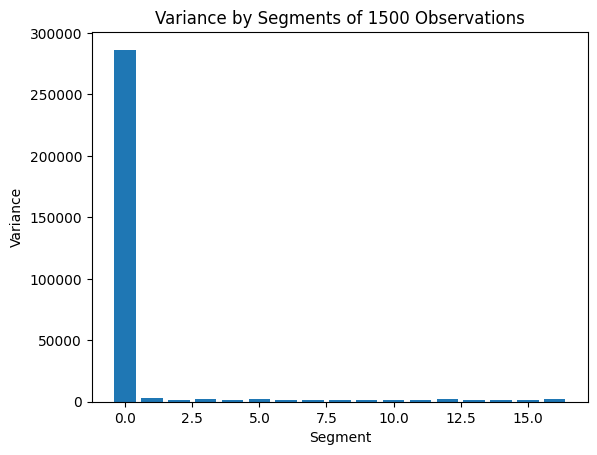

[217501.59943913913, 1507.06147296416, 2023.6758343118424, 1882.1070276072226, 1644.6672183308979, 1834.7164812839237, 1611.7909381892944, 1600.4249210476485, 1599.6206998193077, 1778.924467946496, 1687.6912269562547, 1569.03858554334, 1882.4030296385915]
13


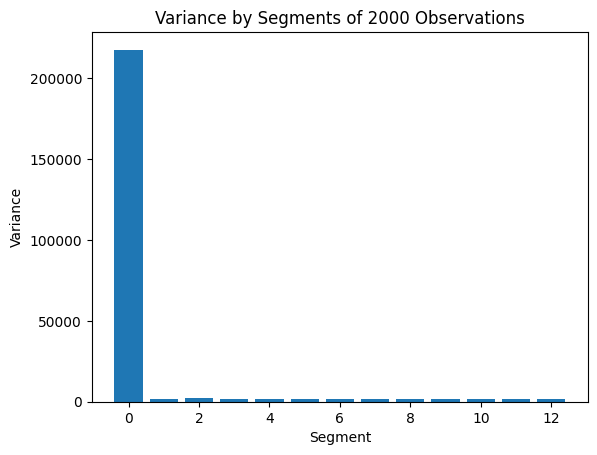

[94310.62815626129, 1777.210207630277, 1732.582120405011, 1663.4599019323475, 1704.528613447714, 0.0]
6


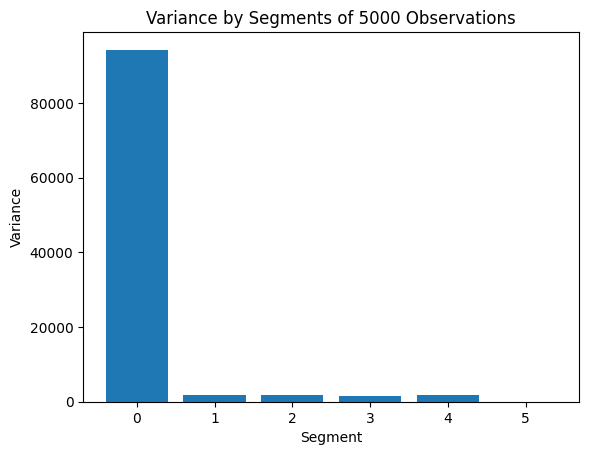

In [23]:
# пример для одной из симуляций
n = 3
print(data[n]["exp_pop10"])
print_all_in_one_frame([data[n]], x="epochs", y = "exp_pop10", limit = 2500)
plt.show()
for size in [100, 300, 500, 1000, 1500, 2000, 5000]:
  data_ = data[n]["exp_pop10"]["exp_pop2"]
  data_segments = [data_[i:i+size] for i in range(0, len(data_), size)]
  variances = [np.var(segment) for segment in data_segments]
  print(variances)
  print(len(variances))
  plt.bar(range(0, len(variances)), variances)
  # Добавляем заголовок и метки осей
  plt.title('Variance by Segments of ' + str(size) + ' Observations')
  plt.xlabel('Segment')
  plt.ylabel('Variance')
  plt.show()


## Подбор порога

In [ ]:
for data